In [2]:
from torchvision import models
import torchvision
import torch
from torch import nn
from torch.utils.data import TensorDataset,DataLoader
import torchvision.transforms as transforms
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt
import numpy as np

import pickle
import gc
from tqdm import tqdm
import pandas as pd
# if you can see this line

In [2]:
work_path = '/local/scratch/yl535/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# generation network

### Building Vocab and predicate vocab

In [3]:
# predicate_list = np.array([])
predicate_list = []
tokenizer = get_tokenizer("basic_english")

for itr in range(2):
    Y_flat = pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/y_preprocessed_{}.p".format(itr), "rb"))
#     y_2 = np.array([tokenizer(w)[0] if w!='' else '/SPACE' for w in Y_flat])
#     predicate_list = np.unique(np.concatenate((predicate_list,y_2)))
    predicate_list.append(Y_flat)
    
predicate_list, predicate_count = np.unique(np.concatenate(predicate_list),return_counts=True)
predicates_table = {w:i for i,w in enumerate(predicate_list)}
predicate_size = len(predicates_table)
predicate_size

7795

In [4]:
predicate_count_loopup = {w:c for w,c in zip(predicate_list,predicate_count)}
predicate_count_loopup

{'ABOVE': 7,
 'ABOVE THE': 19,
 'AND': 15,
 'ARE PARKED ALONGSIDE OF THE': 6,
 'AT': 9,
 'AT THE': 34,
 'ATTACHED TO': 9,
 'Are in': 5,
 'Are on': 6,
 'BEHIND': 6,
 'BEHIND A': 5,
 'BEHIND THE': 12,
 'BELOW': 7,
 'BESIDE THE': 6,
 'BY THE': 20,
 'CARRYING': 7,
 'CLADDING  OF A': 6,
 'COVERED WITH': 5,
 'CROSSING THE': 5,
 'Covers': 6,
 'ENJOYING': 10,
 'FLYING IN THE': 8,
 'FROM': 5,
 'HANGING FROM': 7,
 'HANGING FROM THE': 6,
 'HANGING ON': 17,
 'HAS': 37,
 'HAS A': 44,
 'HOLDING': 12,
 'HOLDING THE': 6,
 'HOLDS': 5,
 'Holds': 7,
 'IN': 37876,
 'IN  THE': 14,
 'IN A': 111,
 'IN FRONT': 14,
 'IN FRONT OF': 16,
 'IN THE': 254,
 'IS': 11,
 'IS HOLDING A': 5,
 'IS ON': 16,
 'IS ON A': 32,
 'IS ON THE': 7,
 'IS WEARING': 31,
 'IS WEARING A': 12,
 'Is behind': 17,
 'Is beside': 6,
 'Is by': 9,
 'Is in': 84,
 'Is inside': 6,
 'Is on': 454,
 'KEY ON': 9,
 'LAYING IN': 7,
 'LEANING AGAINST': 5,
 'MADE OF': 12,
 'NEAR A': 10,
 'NEAR THE': 8,
 'NEXT TO': 42,
 'NEXT TO THE': 5,
 'OF': 128056,
 'O

### Define Model

In [4]:

class WorldModel(nn.Module):
    def __init__(self, pixie_dim, num_semroles):
        super(WorldModel,self).__init__()
        # semantic roles are fixed to 2 here, what if some data has only arg1, some has arg1&arg2 ?
        self.pixie_dim = pixie_dim
        self.num_pixie = num_semroles+1
#         self.W_mu = torch.nn.Parameter(torch.randn(pixie_dim*self.num_pixie))
#         self.W_cov_para = torch.randn(pixie_dim*self.num_pixie,4000)
#         self.W_cov = torch.mm(self.W_cov_para, self.W_cov_para.T)
#         self.W_cov = torch.nn.Parameter(torch.rnadn(pixie_dim*self.num_pixie, pixie_dim*self.num_pixie))
        self.W_mu = torch.zeros(3*pixie_dim)
        self.W_cov = torch.zeros((3*pixie_dim, 3*pixie_dim))
        self.data_size = 0

    def forward(self, x):
        return x
    
    def estimate_parameters(self, x):
        batch_size = x.shape[0]
        mu_batch = torch.mean(x,0) 
        diff = x-mu_batch
        cov_batch = torch.matmul(diff.T,diff)/batch_size
        
        self.W_mu = self.W_mu*(self.data_size/(self.data_size+batch_size)) + mu_batch*(batch_size/(self.data_size+batch_size))
        self.W_cov = self.W_cov*(self.data_size/(self.data_size+batch_size)) + cov_batch*(batch_size/(self.data_size+batch_size))
        self.data_size += batch_size

        return mu_batch, cov_batch
    
    def inverse_cov(self):
        self.W_precision = torch.inverse(self.W_cov)
        
    def neg_energy(self, pixies):
        x = torch.cat(pixies)-self.W_mu
        energy = torch.matmul(torch.matmul(self.W_precision,x),x)
        return energy
    
    def sample_pixie(self):
        sample_seed = torch.normal(0, 1, size=(self.pixie_dim*self.num_pixie, 1))
        Lx = torch.matmul(torch.cholesky(self.W_cov), sample_seed)
        return self.W_mu[:,None].expand_as(Lx) + Lx
    
    def loss(self):
        return 0
        
        

class LexiconModel(nn.Module):
    def __init__(self, pixie_dim, predicate_size):
        super(LexiconModel,self).__init__()
        # lexical parameters
        self.predicate_size = predicate_size
        self.V = torch.nn.Parameter(torch.randn(predicate_size, pixie_dim))

    def forward(self, x, pred):
        truth, prob = self.truth_and_prob(pred, x)
        return truth, prob

    def truth(self, pred, pixie):
        v = self.V[pred,:]
        neg_energy = torch.sum(pixie*v,1)
        return torch.sigmoid(neg_energy)
    
    def all_truth(self, pixie):
        return torch.sigmoid(torch.matmul(pixie, self.V.t()))

    def truth_and_prob(self, pred, pixie):
        truth = self.truth(pred, pixie)
        truth_all = self.all_truth(pixie)
        prob = torch.div(truth, torch.sum(truth_all,1))
        return truth, prob
    

### train world model


In [5]:
## train world model

pixie_dim = 20
num_semroles = 2
world_model = WorldModel(pixie_dim, num_semroles)


for itr in tqdm(range(2)):
    x_hidden = pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/x_preprocessed_{}.p".format(itr), "rb"))
    mu_batch, cov_batch = world_model.estimate_parameters(torch.Tensor(x_hidden).reshape(-1,3*pixie_dim))
#     print(torch.matrix_rank(world_model.W_cov))
    
# plt.matshow(world_model.W_cov, cmap=plt.cm.Blues)


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


In [6]:
pickle.dump([world_model.W_mu.cpu().detach(), world_model.W_cov.cpu().detach()], open("world_parameters.p", "wb"))


### train lexicon model

In [7]:
pixie_dim=20
learning_rate = 0.01
decay_rate = 0.0000000001
batch_size = 1000

lexmodel = LexiconModel(pixie_dim, predicate_size)
lexmodel.to(device)
optimizer = torch.optim.Adam(lexmodel.parameters(), lr=learning_rate, weight_decay = decay_rate)

loss_log = []
loss_log_valid = []
prob_log = [] 
truth_log = []
for epoch in tqdm(range(30)):
    if np.mod(epoch,5)==0 and epoch!=0:
        learning_rate = learning_rate*0.3
    
    lexmodel.train()
    loss_global = []
    prob_global = []
    truth_global = []
    for itr in range(2):
        x_hidden = torch.Tensor(pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/x_preprocessed_{}.p".format(itr), "rb")))
        Y_flat = pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/y_preprocessed_{}.p".format(itr), "rb"))

        y_token = np.array([predicates_table[y_pred] for triple in Y_flat for y_pred in triple])
        
        xLoader = DataLoader(x_hidden.reshape((-1,pixie_dim)), batch_size=batch_size)
        yLoader = DataLoader(y_token, batch_size=batch_size)

        word_learnt = []
        for idx,(x,y) in enumerate(zip(xLoader, yLoader)):
            optimizer.zero_grad()
            truth, prob = lexmodel(x.to(device), y.to(device))
            pred_loss = torch.sum(-torch.log(truth+0.01))*1.5 + torch.sum(- torch.log(prob+0.01))
#             pred_loss = torch.sum( - torch.log(prob+0.01))

            pred_loss.backward()
            optimizer.step()   
            
            loss_global.append(pred_loss.item()/len(x))
            prob_global.append(prob.detach().cpu())
            truth_global.append(truth.detach().cpu())
            word_learnt.append(torch.unique(y[prob>0.01]))
    print(predicate_list[torch.unique(torch.cat(word_learnt))],len(torch.unique(torch.cat(word_learnt))))
    loss_log.append(np.mean(loss_global))
    
    # evaluate validation:
    lexmodel.eval()
    loss_global_valid = []
    prob_global_valid = []
    truth_global_valid = []
    with torch.no_grad():
        for itr in range(1,2):
            x_hidden = torch.Tensor(pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/x_preprocessed_{}.p".format(itr), "rb")))
            Y_flat = pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/y_preprocessed_{}.p".format(itr), "rb"))

#             y_2 = np.array([tokenizer(w)[0] if w!='' else '/SPACE' for w in Y_flat]) # there's empty predicate, but we cannot easily remove that 
#             y_token = np.array([predicates_table[w] for w in y_2])
            y_token = np.array([predicates_table[y_pred] for triple in Y_flat for y_pred in triple])

            xLoader = DataLoader(x_hidden.reshape((-1,pixie_dim)), batch_size=batch_size)
            yLoader = DataLoader(y_token, batch_size=batch_size)

            for idx,(x,y) in enumerate(zip(xLoader, yLoader)):
                truth, prob = lexmodel(x.to(device), y.to(device))
                pred_loss = torch.sum(-torch.log(truth+0.01))*1.5 + torch.sum(- torch.log(prob+0.01))
#                 pred_loss = torch.sum( - torch.log(prob+0.01))

                loss_global_valid.append(pred_loss.item()/len(x))
                prob_global_valid.append(prob.detach().cpu())
                truth_global_valid.append(truth.detach().cpu())

        
#     prob_log.append(torch.mean(torch.cat(prob_global)))
#     truth_log.append(torch.mean(torch.cat(truth_global)))
    
    loss_log_valid.append(np.mean(loss_global_valid))

#             if idx%100==0:
    print('training dataset:')
    print('truth: ', torch.mean(torch.cat(truth_global)))
    print('prob: ', torch.mean(torch.cat(prob_global)))
    print('loss: ', np.mean(loss_global))
    print('----------------------')
    print('validation dataset:')
    print('truth: ', torch.mean(torch.cat(truth_global_valid)))
    print('prob: ', torch.mean(torch.cat(prob_global_valid)))
    print('loss: ', np.mean(loss_global_valid))
    print('=========================')




  0%|          | 0/30 [00:00<?, ?it/s]

[] 0



  3%|▎         | 1/30 [01:04<31:24, 64.97s/it]

training dataset:
truth:  tensor(0.9413)
prob:  tensor(0.0012)
loss:  4.790239335828735
----------------------
validation dataset:
truth:  tensor(0.9669)
prob:  tensor(0.0013)
loss:  4.6490506222540855
['IN' 'OF' 'ON' 'about' 'above' 'along' 'animal' 'around' 'background'
 'be' 'behind' 'between' 'confront' 'cow' 'crop' 'eat' 'enclosure' 'field'
 'giraffe' 'grass' 'has' 'have' 'in' 'land' 'leg' 'near' 'next' 'next to'
 'of a' 'photograph' 'road' 'run' 'sand' 'savannah' 'soil' 'stand'
 'standing in' 'standing on' 'traverse' 'tree' 'under' 'walk' 'with'
 'zebra'] 44



  7%|▋         | 2/30 [02:07<29:57, 64.21s/it]

training dataset:
truth:  tensor(0.9601)
prob:  tensor(0.0019)
loss:  4.631904802409004
----------------------
validation dataset:
truth:  tensor(0.9612)
prob:  tensor(0.0022)
loss:  4.602434455452101
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'adult'
 'against' 'air' 'airplane' 'airport' 'along' 'alongside' 'among' 'and'
 'animal' 'antelope' 'approximately' 'arch' 'are in' 'are on' 'area'
 'around' 'asphalt' 'at' 'attach' 'attached to' 'avant-garde' 'away'
 'baby' 'back' 'background' 'backpack' 'bag' 'baggage' 'ball_field'
 'ballplayer' 'band' 'bank' 'barn' 'base' 'baseball' 'batch' 'bathroom'
 'batter' 'be' 'beach' 'bear' 'become' 'bed' 'bedspread' 'behind'
 'belong_to' 'belonging to' 'below' 'bench' 'beside' 'between' 'bicycle'
 'bird' 'blanket' 'bloomers' 'board' 'boat' 'body' 'boulder' 'branch'
 'brick' 'building' 'built into' 'bull' 'bumper' 'bus' 'by' 'cab'
 'cabinet' 'calf' 'camper' 'car' 'carrying' 'cart' 'cat' 'catcher'
 'cattle' 'cell' 'cellular_telephone' '


 10%|█         | 3/30 [03:12<29:03, 64.56s/it]

training dataset:
truth:  tensor(0.9486)
prob:  tensor(0.0033)
loss:  4.593788751662293
----------------------
validation dataset:
truth:  tensor(0.9500)
prob:  tensor(0.0035)
loss:  4.576434380650058
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad'
 'adorning' 'adult' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'among' 'amour_propre' 'and' 'animal' 'antelope' 'apparel'
 'approximately' 'arch' 'are attached to' 'are in' 'are on' 'area' 'arm'
 'around' 'arrive' 'asphalt' 'associate' 'at' 'at a' 'athlete' 'attach'
 'attached to' 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag'
 'baggage' 'ball' 'ball_field' 'ballplayer' 'band' 'bank' 'banner' 'barn'
 'base' 'baseball' 'baseball_diamond' 'bat' 'batch' 'bathroom' 'bathtub'
 'battalion' 'batter' 'be' 'beach' 'bear' 'become' 'bed' 'bedroom'
 'bedspread' 'behind' 'belong_to' 'belonging to' 'below' 'bench' 'beside'
 'between' 'bicycle' 'bird' 'black' 'blanket' 'blazer' 'bleacher'
 'bloomers' 'blue' 'board'


 13%|█▎        | 4/30 [04:17<27:55, 64.46s/it]

training dataset:
truth:  tensor(0.9373)
prob:  tensor(0.0048)
loss:  4.567259094890934
----------------------
validation dataset:
truth:  tensor(0.9413)
prob:  tensor(0.0045)
loss:  4.564566341213096
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad'
 'adorning' 'adult' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'alongside' 'amour_propre' 'and' 'animal' 'antelope' 'apartment'
 'apparel' 'appliance' 'approximately' 'arch' 'are attached to' 'are in'
 'are on' 'area' 'arm' 'around' 'arrive' 'arrow' 'asphalt' 'associate'
 'at' 'at a' 'athlete' 'attach' 'attached to' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bag' 'baggage' 'ball' 'ball_field' 'ballplayer'
 'band' 'bank' 'banner' 'barn' 'base' 'baseball' 'baseball_diamond' 'bat'
 'batch' 'bathroom' 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon'
 'bear' 'become' 'bed' 'bedroom' 'bedspread' 'behind' 'belong_to'
 'belonging to' 'below' 'bench' 'beside' 'between' 'bicycle' 'bird'
 'black' 'blanket' 


 17%|█▋        | 5/30 [05:19<26:36, 63.86s/it]

training dataset:
truth:  tensor(0.9313)
prob:  tensor(0.0057)
loss:  4.552928037663473
----------------------
validation dataset:
truth:  tensor(0.9367)
prob:  tensor(0.0051)
loss:  4.55763082641853
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad'
 'adorning' 'adult' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'alongside' 'american_bison' 'among' 'amour_propre' 'and'
 'animal' 'antelope' 'apartment' 'apparel' 'appliance' 'approximately'
 'apron' 'arch' 'are attached to' 'are in' 'are on' 'area' 'arm' 'around'
 'arrive' 'arrow' 'asphalt' 'associate' 'at' 'at a' 'athlete' 'attach'
 'attached to' 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag'
 'baggage' 'ball' 'ball_field' 'ballplayer' 'banana' 'band' 'bank'
 'banner' 'barn' 'barroom' 'base' 'baseball' 'baseball_diamond' 'bat'
 'batch' 'bath' 'bathroom' 'bathtub' 'battalion' 'batter' 'be' 'beach'
 'beacon' 'bear' 'become' 'bed' 'bedroom' 'bedspread' 'behind' 'belong_to'
 'belonging to' 'below' 'ben


 20%|██        | 6/30 [06:21<25:22, 63.45s/it]

training dataset:
truth:  tensor(0.9282)
prob:  tensor(0.0062)
loss:  4.544739204385271
----------------------
validation dataset:
truth:  tensor(0.9339)
prob:  tensor(0.0055)
loss:  4.554660510634259
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad' 'adult'
 'aftermath' 'against' 'air' 'aircraft' 'airplane' 'airport' 'along'
 'american_bison' 'among' 'amour_propre' 'and' 'animal' 'antelope'
 'apartment' 'apparel' 'appliance' 'approximately' 'apron' 'arch' 'are in'
 'are on' 'area' 'arm' 'around' 'arrive' 'arrow' 'asphalt' 'associate'
 'at' 'at a' 'athlete' 'attach' 'attached to' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bag' 'baggage' 'balcony' 'ball' 'ball_field'
 'ballplayer' 'banana' 'band' 'bank' 'banner' 'barn' 'barroom' 'base'
 'baseball' 'baseball_diamond' 'basin' 'bat' 'batch' 'bath' 'bathroom'
 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bear' 'become'
 'bed' 'bedroom' 'bedspread' 'behind' 'belong_to' 'belonging to' 'below'
 'bench' 'besid


 23%|██▎       | 7/30 [07:27<24:34, 64.10s/it]

training dataset:
truth:  tensor(0.9264)
prob:  tensor(0.0066)
loss:  4.539847055950546
----------------------
validation dataset:
truth:  tensor(0.9323)
prob:  tensor(0.0057)
loss:  4.55246417009082
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad'
 'adorning' 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane'
 'airport' 'along' 'alongside' 'american_bison' 'among' 'amour_propre'
 'and' 'animal' 'antelope' 'apartment' 'apparel' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'asphalt' 'associate' 'at' 'athlete' 'attach'
 'attached to' 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag'
 'baggage' 'balcony' 'ball' 'ball_field' 'balloon' 'ballplayer' 'banana'
 'band' 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball' 'baseball_bat'
 'baseball_diamond' 'basin' 'bat' 'batch' 'bath' 'bathroom' 'bathtub'
 'battalion' 'batter' 'be' 'beach' 'beacon' 'bear' 'become' 'bed'
 'bedroom' 'bedspread' 'behind


 27%|██▋       | 8/30 [08:31<23:26, 63.92s/it]

training dataset:
truth:  tensor(0.9254)
prob:  tensor(0.0068)
loss:  4.536718006097578
----------------------
validation dataset:
truth:  tensor(0.9314)
prob:  tensor(0.0059)
loss:  4.550999465012528
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad'
 'adorning' 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane'
 'airport' 'along' 'alongside' 'american_bison' 'among' 'amour_propre'
 'and' 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'asphalt' 'associate' 'at' 'athlete' 'attach'
 'attached to' 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag'
 'baggage' 'balcony' 'ball' 'ball_field' 'balloon' 'ballplayer' 'banana'
 'band' 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball' 'baseball_bat'
 'baseball_diamond' 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom'
 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bear' 'become'
 'bed' 'bedroom' '


 30%|███       | 9/30 [09:34<22:16, 63.63s/it]

training dataset:
truth:  tensor(0.9248)
prob:  tensor(0.0070)
loss:  4.534494301479426
----------------------
validation dataset:
truth:  tensor(0.9307)
prob:  tensor(0.0060)
loss:  4.549838068053882
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad'
 'adorning' 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane'
 'airport' 'along' 'alongside' 'american_bison' 'among' 'amour_propre'
 'and' 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'asphalt' 'associate' 'at' 'athlete' 'attach'
 'attached to' 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag'
 'bagel' 'baggage' 'balcony' 'ball' 'ball_field' 'balloon' 'ballplayer'
 'banana' 'band' 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball'
 'baseball_bat' 'baseball_diamond' 'basin' 'basket' 'bat' 'batch' 'bath'
 'bathroom' 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bear'
 'become' 'bed' 'be


 33%|███▎      | 10/30 [10:35<20:59, 62.99s/it]

training dataset:
truth:  tensor(0.9244)
prob:  tensor(0.0071)
loss:  4.5327504432232875
----------------------
validation dataset:
truth:  tensor(0.9302)
prob:  tensor(0.0061)
loss:  4.549320214358764
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad'
 'adorning' 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane'
 'airport' 'along' 'alongside' 'american_bison' 'among' 'amour_propre'
 'and' 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'asphalt' 'associate' 'at' 'athlete' 'attach'
 'attached to' 'audience' 'avant-garde' 'baby' 'back' 'background'
 'backpack' 'bag' 'bagel' 'baggage' 'ball' 'ball_field' 'balloon'
 'ballplayer' 'banana' 'band' 'bank' 'banner' 'barn' 'barroom' 'base'
 'baseball' 'baseball_bat' 'baseball_diamond' 'basin' 'basket' 'bat'
 'batch' 'bath' 'bathroom' 'bathtub' 'battalion' 'batter' 'be' 'beach'
 'beacon' 'bear' 'become' 'bed' '


 37%|███▋      | 11/30 [11:37<19:48, 62.54s/it]

training dataset:
truth:  tensor(0.9242)
prob:  tensor(0.0072)
loss:  4.5315323872154725
----------------------
validation dataset:
truth:  tensor(0.9299)
prob:  tensor(0.0062)
loss:  4.5488290890046885
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad'
 'adorning' 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane'
 'airport' 'along' 'alongside' 'american_bison' 'amour_propre' 'and'
 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'artwork' 'asphalt' 'associate' 'at' 'athlete'
 'attach' 'attached to' 'audience' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bag' 'bagel' 'baggage' 'ball' 'ball_field'
 'balloon' 'ballplayer' 'banana' 'band' 'bank' 'banner' 'barn' 'barroom'
 'base' 'baseball' 'baseball_bat' 'baseball_diamond' 'basin' 'basket'
 'bat' 'batch' 'bath' 'bathroom' 'bathtub' 'battalion' 'batter' 'be'
 'beach' 'beacon' 'bear' 'become' 'bed


 40%|████      | 12/30 [12:42<19:01, 63.40s/it]

training dataset:
truth:  tensor(0.9241)
prob:  tensor(0.0073)
loss:  4.530413447961715
----------------------
validation dataset:
truth:  tensor(0.9296)
prob:  tensor(0.0063)
loss:  4.548758435841304
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad'
 'adorning' 'adult' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'american_bison' 'among' 'amour_propre' 'and' 'animal' 'antelope'
 'apartment' 'apparel' 'apple' 'appliance' 'approximately' 'apron' 'arch'
 'are in' 'are on' 'area' 'arm' 'armchair' 'around' 'arrive' 'arrow'
 'artwork' 'asphalt' 'associate' 'at' 'athlete' 'attach' 'attached to'
 'audience' 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bacon'
 'bag' 'bagel' 'baggage' 'ball' 'ball_field' 'balloon' 'ballplayer'
 'banana' 'band' 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball'
 'baseball_bat' 'baseball_diamond' 'basin' 'basket' 'bat' 'batch' 'bath'
 'bathroom' 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bear'
 'become' 'bed' 'bedroom


 43%|████▎     | 13/30 [13:45<17:57, 63.36s/it]

training dataset:
truth:  tensor(0.9240)
prob:  tensor(0.0073)
loss:  4.5297848116515755
----------------------
validation dataset:
truth:  tensor(0.9293)
prob:  tensor(0.0063)
loss:  4.5485587255964095
['IN' 'OF' 'ON' 'ON THE' 'WEARING' 'about' 'above' 'across' 'ad'
 'adorning' 'adult' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'american_bison' 'among' 'amour_propre' 'and' 'angstrom' 'animal'
 'antelope' 'apartment' 'apparel' 'apple' 'appliance' 'approximately'
 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair' 'around'
 'arrive' 'arrow' 'artwork' 'asphalt' 'associate' 'at' 'athlete' 'attach'
 'attached to' 'audience' 'avant-garde' 'baby' 'back' 'background'
 'backpack' 'bacon' 'bag' 'bagel' 'baggage' 'ball' 'ball_field' 'balloon'
 'ballplayer' 'banana' 'band' 'bank' 'banner' 'barn' 'barroom' 'base'
 'baseball' 'baseball_bat' 'baseball_diamond' 'basin' 'basket' 'bat'
 'batch' 'bath' 'bathroom' 'bathtub' 'battalion' 'batter' 'be' 'beach'
 'beacon' 'bear' 'become' '


 47%|████▋     | 14/30 [14:49<16:56, 63.52s/it]

training dataset:
truth:  tensor(0.9239)
prob:  tensor(0.0074)
loss:  4.529185250373727
----------------------
validation dataset:
truth:  tensor(0.9291)
prob:  tensor(0.0064)
loss:  4.54861151239101
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'across' 'ad' 'adult' 'against'
 'air' 'aircraft' 'airplane' 'airport' 'along' 'american_bison' 'among'
 'amour_propre' 'and' 'angstrom' 'animal' 'antelope' 'apartment' 'apparel'
 'apple' 'appliance' 'approximately' 'apron' 'arch' 'are in' 'are on'
 'area' 'arm' 'armchair' 'around' 'arrive' 'arrow' 'artwork' 'asphalt'
 'associate' 'at' 'athlete' 'attach' 'attached to' 'audience'
 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bacon' 'bag' 'bagel'
 'baggage' 'ball' 'ball_field' 'balloon' 'ballplayer' 'banana' 'band'
 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball' 'baseball_bat'
 'baseball_diamond' 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom'
 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bear' 'become'
 'bed' 'bedroom' 'bedspre


 50%|█████     | 15/30 [15:53<15:54, 63.62s/it]

training dataset:
truth:  tensor(0.9239)
prob:  tensor(0.0074)
loss:  4.528718767465657
----------------------
validation dataset:
truth:  tensor(0.9290)
prob:  tensor(0.0064)
loss:  4.5486836229532175
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'across' 'ad' 'adult' 'against'
 'air' 'aircraft' 'airplane' 'airport' 'along' 'american_bison'
 'amour_propre' 'and' 'angstrom' 'animal' 'antelope' 'apartment' 'apparel'
 'apple' 'appliance' 'approximately' 'apron' 'arch' 'are in' 'are on'
 'area' 'arm' 'armchair' 'around' 'arrive' 'arrow' 'artwork' 'asphalt'
 'associate' 'at' 'athlete' 'attach' 'attached to' 'audience'
 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag' 'bagel'
 'baggage' 'ball' 'ball_field' 'balloon' 'ballplayer' 'banana' 'band'
 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball' 'baseball_bat'
 'baseball_diamond' 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom'
 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bear' 'become'
 'bed' 'bedroom' 'bedspread' 'beer' 'be


 53%|█████▎    | 16/30 [16:54<14:41, 62.94s/it]

training dataset:
truth:  tensor(0.9239)
prob:  tensor(0.0075)
loss:  4.5283907752417605
----------------------
validation dataset:
truth:  tensor(0.9290)
prob:  tensor(0.0064)
loss:  4.548582725203118
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'across' 'ad' 'adult' 'against'
 'air' 'aircraft' 'airplane' 'airport' 'along' 'american_bison' 'among'
 'amour_propre' 'and' 'angstrom' 'animal' 'antelope' 'apartment' 'apparel'
 'apple' 'appliance' 'approximately' 'apron' 'arch' 'are in' 'are on'
 'area' 'arm' 'armchair' 'around' 'arrive' 'arrow' 'artwork' 'asphalt'
 'associate' 'at' 'athlete' 'attach' 'attached to' 'audience'
 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag' 'bagel'
 'baggage' 'ball' 'ball_field' 'balloon' 'ballplayer' 'banana' 'band'
 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball' 'baseball_bat'
 'baseball_diamond' 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom'
 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bear' 'become'
 'bed' 'bedroom' 'bedspread' 'b


 57%|█████▋    | 17/30 [17:58<13:40, 63.12s/it]

training dataset:
truth:  tensor(0.9239)
prob:  tensor(0.0075)
loss:  4.5280898212755805
----------------------
validation dataset:
truth:  tensor(0.9289)
prob:  tensor(0.0065)
loss:  4.548479484501124
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'across' 'ad' 'adult' 'against'
 'air' 'aircraft' 'airplane' 'airport' 'along' 'american_bison' 'among'
 'amour_propre' 'and' 'angstrom' 'animal' 'antelope' 'apartment' 'apparel'
 'apple' 'appliance' 'approximately' 'apron' 'arch' 'are in' 'are on'
 'area' 'arm' 'armchair' 'around' 'arrive' 'arrow' 'artwork' 'asphalt'
 'associate' 'at' 'athlete' 'attach' 'attached to' 'audience'
 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag' 'bagel'
 'baggage' 'ball' 'ball_field' 'balloon' 'ballplayer' 'banana' 'band'
 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball' 'baseball_bat'
 'baseball_diamond' 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom'
 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bean' 'bear'
 'become' 'bed' 'bedroom' 'bedspr


 60%|██████    | 18/30 [19:02<12:39, 63.28s/it]

training dataset:
truth:  tensor(0.9239)
prob:  tensor(0.0075)
loss:  4.527818697734824
----------------------
validation dataset:
truth:  tensor(0.9288)
prob:  tensor(0.0065)
loss:  4.548689731303574
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'across' 'ad' 'adult' 'against'
 'air' 'aircraft' 'airplane' 'airport' 'along' 'american_bison' 'among'
 'amour_propre' 'and' 'angstrom' 'animal' 'antelope' 'apartment' 'apparel'
 'apple' 'appliance' 'approximately' 'apron' 'arch' 'are in' 'are on'
 'area' 'arm' 'armchair' 'around' 'arrive' 'arrow' 'artwork' 'asphalt'
 'associate' 'at' 'athlete' 'attach' 'attached to' 'audience'
 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag' 'bagel'
 'baggage' 'ball' 'ball_field' 'balloon' 'ballplayer' 'banana' 'band'
 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball' 'baseball_bat'
 'baseball_diamond' 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom'
 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bean' 'bear'
 'become' 'bed' 'bedroom' 'bedspre


 63%|██████▎   | 19/30 [20:04<11:35, 63.19s/it]

training dataset:
truth:  tensor(0.9239)
prob:  tensor(0.0075)
loss:  4.527591969185824
----------------------
validation dataset:
truth:  tensor(0.9287)
prob:  tensor(0.0065)
loss:  4.548714547691113
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'across' 'ad' 'adult' 'against'
 'air' 'aircraft' 'airplane' 'airport' 'along' 'american_bison' 'among'
 'amour_propre' 'and' 'angstrom' 'animal' 'antelope' 'apartment' 'apparel'
 'apple' 'appliance' 'approximately' 'apron' 'arch' 'are in' 'are on'
 'area' 'arm' 'armchair' 'around' 'arrive' 'arrow' 'artwork' 'asphalt'
 'associate' 'at' 'athlete' 'attach' 'attached to' 'audience'
 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag' 'bagel'
 'baggage' 'ball' 'ball_field' 'balloon' 'ballplayer' 'banana' 'band'
 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball' 'baseball_bat'
 'baseball_diamond' 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom'
 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bean' 'bear'
 'become' 'bed' 'bedroom' 'bedspre


 67%|██████▋   | 20/30 [21:10<10:40, 64.02s/it]

training dataset:
truth:  tensor(0.9239)
prob:  tensor(0.0076)
loss:  4.527515326607421
----------------------
validation dataset:
truth:  tensor(0.9287)
prob:  tensor(0.0066)
loss:  4.548821857910139
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'across' 'ad' 'adult' 'against'
 'air' 'aircraft' 'airplane' 'airport' 'along' 'american_bison' 'among'
 'amour_propre' 'and' 'angstrom' 'animal' 'antelope' 'apartment' 'apparel'
 'apple' 'appliance' 'approximately' 'apron' 'arch' 'are in' 'are on'
 'area' 'arm' 'armchair' 'around' 'arrive' 'arrow' 'artwork' 'asphalt'
 'associate' 'at' 'athlete' 'attach' 'attached to' 'audience'
 'avant-garde' 'baby' 'back' 'background' 'backpack' 'bag' 'bagel'
 'baggage' 'ball' 'ball_field' 'balloon' 'ballplayer' 'banana' 'band'
 'bank' 'banner' 'barn' 'barroom' 'base' 'baseball' 'baseball_bat'
 'baseball_diamond' 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom'
 'bathtub' 'battalion' 'batter' 'be' 'beach' 'beacon' 'bean' 'bear'
 'become' 'bed' 'bedroom' 'bedspre


 70%|███████   | 21/30 [22:12<09:29, 63.31s/it]

training dataset:
truth:  tensor(0.9240)
prob:  tensor(0.0076)
loss:  4.5273417137704755
----------------------
validation dataset:
truth:  tensor(0.9286)
prob:  tensor(0.0066)
loss:  4.54881166256497
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'across' 'ad' 'adult'
 'aftermath' 'against' 'air' 'aircraft' 'airplane' 'airport' 'along'
 'ambulance' 'american_bison' 'among' 'amour_propre' 'and' 'angstrom'
 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'artwork' 'asphalt' 'associate' 'at' 'athlete'
 'attach' 'attached to' 'audience' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bag' 'bagel' 'baggage' 'ball' 'ball_field'
 'balloon' 'ballplayer' 'banana' 'band' 'bank' 'banner' 'barn' 'barroom'
 'base' 'baseball' 'baseball_bat' 'baseball_diamond' 'basin' 'basket'
 'bat' 'batch' 'bath' 'bathroom' 'bathtub' 'battalion' 'batter' 'be'
 'beach' 'beacon' 'bean' 'bear' 'become' 


 73%|███████▎  | 22/30 [23:16<08:27, 63.46s/it]

training dataset:
truth:  tensor(0.9240)
prob:  tensor(0.0076)
loss:  4.527263808853521
----------------------
validation dataset:
truth:  tensor(0.9284)
prob:  tensor(0.0066)
loss:  4.548994376037259
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'across' 'ad' 'adult'
 'aftermath' 'against' 'air' 'aircraft' 'airplane' 'airport' 'along'
 'ambulance' 'american_bison' 'among' 'amour_propre' 'and' 'angstrom'
 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'artwork' 'asphalt' 'associate' 'at' 'athlete'
 'attach' 'attached to' 'audience' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bag' 'bagel' 'baggage' 'ball' 'ball_field'
 'balloon' 'ballplayer' 'banana' 'band' 'bank' 'banner' 'barn' 'barroom'
 'base' 'baseball' 'baseball_bat' 'baseball_diamond' 'basin' 'basket'
 'bat' 'batch' 'bath' 'bathroom' 'bathtub' 'battalion' 'batter' 'be'
 'beach' 'beacon' 'bean' 'bear' 'become' 


 77%|███████▋  | 23/30 [24:20<07:25, 63.63s/it]

training dataset:
truth:  tensor(0.9240)
prob:  tensor(0.0076)
loss:  4.527248390381551
----------------------
validation dataset:
truth:  tensor(0.9283)
prob:  tensor(0.0067)
loss:  4.549082902713759
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'accountant' 'across' 'ad'
 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'ambulance' 'american_bison' 'amour_propre' 'and' 'angstrom'
 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'art' 'artwork' 'asphalt' 'associate' 'at'
 'athlete' 'attach' 'attached to' 'audience' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bag' 'bagel' 'baggage' 'ball' 'ball_field'
 'balloon' 'ballplayer' 'banana' 'band' 'bank' 'banner' 'barn' 'barroom'
 'base' 'baseball' 'baseball_bat' 'baseball_diamond' 'basin' 'basket'
 'bat' 'batch' 'bath' 'bathroom' 'bathtub' 'battalion' 'batter' 'be'
 'beach' 'beacon' 'bean' 'bear


 80%|████████  | 24/30 [25:23<06:20, 63.42s/it]

training dataset:
truth:  tensor(0.9239)
prob:  tensor(0.0077)
loss:  4.527181535485597
----------------------
validation dataset:
truth:  tensor(0.9282)
prob:  tensor(0.0067)
loss:  4.549396108262022
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'accountant' 'across' 'ad'
 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'ambulance' 'american_bison' 'among' 'amour_propre' 'and'
 'angstrom' 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'art' 'artwork' 'asphalt' 'associate' 'at'
 'athlete' 'attach' 'attached to' 'audience' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bag' 'bagel' 'baggage' 'ball' 'ball_field'
 'balloon' 'ballplayer' 'banana' 'band' 'bank' 'banner' 'barn' 'barroom'
 'base' 'baseball' 'baseball_bat' 'baseball_diamond' 'basin' 'basket'
 'bat' 'batch' 'bath' 'bathroom' 'bathtub' 'battalion' 'batter' 'be'
 'beach' 'beacon' 'bea


 83%|████████▎ | 25/30 [26:27<05:18, 63.77s/it]

training dataset:
truth:  tensor(0.9239)
prob:  tensor(0.0077)
loss:  4.527175204548623
----------------------
validation dataset:
truth:  tensor(0.9281)
prob:  tensor(0.0067)
loss:  4.549571867429479
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'accountant' 'across' 'ad'
 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'ambulance' 'american_bison' 'among' 'amour_propre' 'and'
 'angstrom' 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'art' 'artwork' 'asphalt' 'associate' 'at'
 'athlete' 'attach' 'attached to' 'audience' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bag' 'bagel' 'baggage' 'ball' 'ball_field'
 'balloon' 'ballplayer' 'banana' 'band' 'bank' 'banner' 'barn' 'barroom'
 'base' 'baseball' 'baseball_bat' 'baseball_diamond' 'basin' 'basket'
 'bat' 'batch' 'bath' 'bathroom' 'bathtub' 'battalion' 'batter' 'be'
 'beach' 'beacon' 'bea


 87%|████████▋ | 26/30 [27:34<04:18, 64.52s/it]

training dataset:
truth:  tensor(0.9239)
prob:  tensor(0.0077)
loss:  4.527077350714425
----------------------
validation dataset:
truth:  tensor(0.9281)
prob:  tensor(0.0067)
loss:  4.549495209001123
['IN' 'OF' 'ON' 'ON A' 'WEARING' 'about' 'above' 'accountant' 'across'
 'ad' 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'ambulance' 'american_bison' 'amour_propre' 'and' 'angstrom'
 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'art' 'artwork' 'asphalt' 'associate' 'at'
 'athlete' 'attach' 'attached to' 'audience' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bag' 'bagel' 'baggage' 'ball' 'ball_field'
 'balloon' 'ballplayer' 'banana' 'band' 'bank' 'banner' 'barn' 'barroom'
 'base' 'baseball' 'baseball_bat' 'baseball_diamond' 'basin' 'basket'
 'bat' 'batch' 'bath' 'bathroom' 'bathtub' 'battalion' 'batter' 'be'
 'beach' 'beacon' 'bean


 90%|█████████ | 27/30 [28:53<03:26, 68.91s/it]

training dataset:
truth:  tensor(0.9240)
prob:  tensor(0.0077)
loss:  4.526937358382899
----------------------
validation dataset:
truth:  tensor(0.9281)
prob:  tensor(0.0068)
loss:  4.549720360920201
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'accountant' 'across' 'ad'
 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'ambulance' 'american_bison' 'among' 'amour_propre' 'and'
 'angstrom' 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'art' 'artwork' 'asphalt' 'associate' 'at'
 'athlete' 'attach' 'attached to' 'audience' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bacon' 'bag' 'bagel' 'baggage' 'ball'
 'ball_field' 'balloon' 'ballplayer' 'banana' 'band' 'bank' 'banner'
 'barn' 'barroom' 'base' 'baseball' 'baseball_bat' 'baseball_diamond'
 'basil' 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom' 'bathtub'
 'battalion' 'batter' 'be' 'beac


 93%|█████████▎| 28/30 [29:56<02:14, 67.13s/it]

training dataset:
truth:  tensor(0.9240)
prob:  tensor(0.0077)
loss:  4.527022005762975
----------------------
validation dataset:
truth:  tensor(0.9281)
prob:  tensor(0.0068)
loss:  4.549669470900487
['IN' 'OF' 'ON' 'ON A' 'WEARING' 'about' 'above' 'accountant' 'across'
 'ad' 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'ambulance' 'american_bison' 'amour_propre' 'and' 'angstrom'
 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'art' 'artwork' 'asphalt' 'associate' 'at'
 'athlete' 'attach' 'attached to' 'audience' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bacon' 'bag' 'bagel' 'baggage' 'ball'
 'ball_field' 'balloon' 'ballplayer' 'banana' 'band' 'bank' 'banner'
 'barn' 'barroom' 'base' 'baseball' 'baseball_bat' 'baseball_diamond'
 'basil' 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom' 'bathtub'
 'battalion' 'batter' 'be' 'beach


 97%|█████████▋| 29/30 [31:01<01:06, 66.52s/it]

training dataset:
truth:  tensor(0.9240)
prob:  tensor(0.0077)
loss:  4.526949723559678
----------------------
validation dataset:
truth:  tensor(0.9280)
prob:  tensor(0.0068)
loss:  4.549768166689742
['IN' 'OF' 'ON' 'WEARING' 'about' 'above' 'accountant' 'across' 'ad'
 'adult' 'aftermath' 'against' 'air' 'aircraft' 'airplane' 'airport'
 'along' 'ambulance' 'american_bison' 'among' 'amour_propre' 'and'
 'angstrom' 'animal' 'antelope' 'apartment' 'apparel' 'apple' 'appliance'
 'approximately' 'apron' 'arch' 'are in' 'are on' 'area' 'arm' 'armchair'
 'around' 'arrive' 'arrow' 'art' 'artwork' 'asphalt' 'associate' 'at'
 'athlete' 'attach' 'attached to' 'audience' 'avant-garde' 'baby' 'back'
 'background' 'backpack' 'bacon' 'bag' 'bagel' 'baggage' 'ball'
 'ball_field' 'balloon' 'ballplayer' 'banana' 'band' 'bank' 'banner'
 'barn' 'barroom' 'base' 'baseball' 'baseball_bat' 'baseball_diamond'
 'basin' 'basket' 'bat' 'batch' 'bath' 'bathroom' 'bathtub' 'battalion'
 'batter' 'be' 'beach' 'beac


100%|██████████| 30/30 [32:05<00:00, 64.19s/it]

training dataset:
truth:  tensor(0.9240)
prob:  tensor(0.0078)
loss:  4.52692641286339
----------------------
validation dataset:
truth:  tensor(0.9279)
prob:  tensor(0.0068)
loss:  4.549890315265989


In [8]:
pickle.dump(lexmodel.V.cpu().detach(), open("Lexical_parameters.p", "wb"))


In [81]:
pickle.dump(lexmodel.V.cpu().detach(), open("Lexical_parameters_2.p", "wb"))


In [78]:

torch.var(lexmodel.V,0),lexmodel.V.cpu().detach()

(tensor([ 2.8871,  6.1522,  1.2384, 22.4151,  4.8624,  5.6235,  0.1223, 29.5065,
          0.1049, 20.2245,  3.8922, 11.8427,  1.0741,  0.5456, 11.0762,  2.5311,
          0.8092,  2.3798,  4.3481,  3.0130], device='cuda:0',
        grad_fn=<VarBackward1>),
 tensor([[-5.4330, -4.1101, -4.8652,  ...,  6.2702, -6.8177,  7.0926],
         [-5.5834, -4.2412, -4.9968,  ...,  6.4337, -7.0186,  7.2926],
         [-5.4660, -4.1389, -4.8941,  ...,  6.3060, -6.8619,  7.1366],
         ...,
         [-5.5746, -4.2334, -4.9890,  ...,  6.4241, -7.0068,  7.2809],
         [-0.3485,  4.5382, -1.6430,  ...,  2.6348, -1.3053,  2.1091],
         [-5.5575, -4.2186, -4.9741,  ...,  6.4054, -6.9840,  7.2582]]))

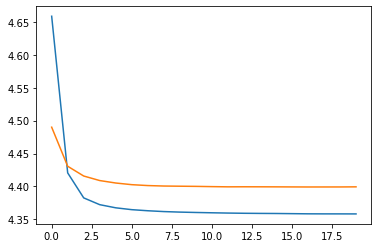

In [28]:
plt.plot(list(range(len(loss_log))),np.array([loss_log, loss_log_valid]).T)
plt.show()

# Evaluation

### Direct Evaluation


In [15]:
from pingouin import multivariate_normality
from scipy import stats
from scipy.stats import shapiro
import seaborn as sns


/home/yl535/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
d = x_hidden.reshape(-1,20).numpy()[:10000]
d.shape

(10000, 20)

In [127]:
k2, p = stats.normaltest(np.exp(d[:100,3]))
k2, p

(26.07633563003691, 2.1756832278191863e-06)

In [7]:
df = pd.DataFrame({'x1':np.random.normal(size=50),
                   'x2': np.random.normal(size=50),
                   'x3': np.random.normal(size=50)})

multivariate_normality(df, alpha=.1)

HZResults(hz=0.40862361597341773, pval=0.9821221137206126, normal=True)

In [26]:
d = x_hidden.reshape(-1,20).numpy()[:5,:10]
print(d.shape)
multivariate_normality(d, alpha=.1)

(5, 10)


HZResults(hz=20, pval=0.0, normal=False)

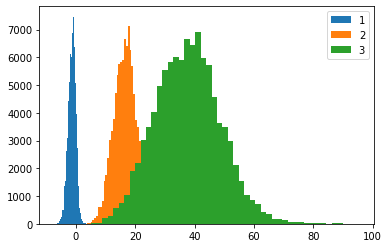

In [8]:
d = x_hidden.reshape(-1,20).numpy()[100000:200000]
feature = 9
plt.hist(d[:,feature],bins=50)
# plt.hist(stats.boxcox(np.exp(d[:,feature]),3),bins=50)
# plt.hist(stats.boxcox(d[:,feature]+10,0),bins=50)
# plt.hist(stats.boxcox(d[:,feature]+10,1),bins=50)
plt.hist(stats.boxcox(d[:,feature]+10,1.5),bins=50)
plt.hist(stats.boxcox(d[:,feature]+10,2),bins=50)

plt.legend(['1','2','3','4'])
plt.show()

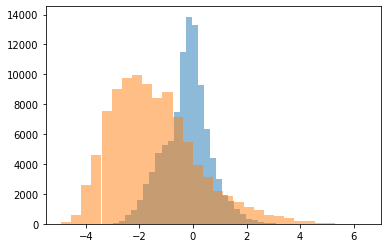

In [11]:
plt.hist(d[:,0],bins=30,alpha=0.5)

plt.hist(d[:,1],bins=30,alpha=0.5)

plt.show()

In [ ]:
mu, sigma = scipy.stats.norm.fit(data)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

In [13]:
best_fit_line

array([9.65049478e-04, 2.37817221e-03, 5.45924839e-03, 1.16739862e-02,
       2.32541961e-02, 4.31498839e-02, 7.45854269e-02, 1.20094906e-01,
       1.80132194e-01, 2.51683171e-01, 3.27576857e-01, 3.97162670e-01,
       4.48559204e-01, 4.71918796e-01, 4.62499145e-01, 4.22231612e-01,
       3.59076274e-01, 2.84458467e-01, 2.09916735e-01, 1.44301730e-01,
       9.24042806e-02, 5.51199604e-02, 3.06282199e-02, 1.58537046e-02,
       7.64427334e-03, 3.43350379e-03, 1.43659715e-03, 5.59923395e-04,
       2.03291104e-04, 6.87549989e-05, 2.16613904e-05])

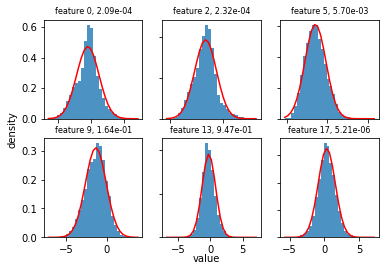

In [16]:
%matplotlib inline

d = x_hidden.reshape(-1,20).numpy()[100000:200000]
fig, axs = plt.subplots(2, 3)

features = [0,2,5,9,13,17]
cnt = 0
for i in range(2):
    for j in range(3):
        k2, p = stats.normaltest(d[:100,features[cnt]])
        
        _,bins,_ = axs[i, j].hist(d[:,features[cnt]], bins=30,density=1,alpha=0.8)
        axs[i, j].set_title('feature {}, {:.2e}'.format(features[cnt],p),fontsize=8)
        mu, sigma = stats.norm.fit(d[:,features[cnt]])
        best_fit_line = stats.norm.pdf(bins, mu, sigma)
        axs[i, j].plot(bins, best_fit_line,'r')
        cnt+=1

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.text(0.5, 0.04, 'value', ha='center')
fig.text(0.04, 0.5, 'density', va='center', rotation='vertical')
plt.show()

In [20]:
def flat(x):
    return np.sqrt(np.abs(x)) * np.sign(x)

def neg_flat(x):
    return np.sqrt(np.max(x)+1-x)

### Train inference network

In [14]:

def approx_E_log_sig(mean, cov, preds):
    # This is the approximation of E[log(Sigmoid(pred*pixie))]
    # mean and cov are the parameters of the q(s), estimated by inference network
    # preds has dimension N*Dim_pixie, where N is the number of predicate.
    a = 0.205
    b = -0.319
    c = 0.781
    d = 0.870
    def compute_variance_sum(preds,cov):
        return torch.sum(torch.mul(preds.T, torch.mm(cov,preds.T)),0)
    
    temp = (torch.matmul(preds, mean) + b*(compute_variance_sum(preds,cov).pow(c)))/ \
           torch.sqrt(1+a*(compute_variance_sum(preds,cov).pow(d)))
    
    return torch.log(torch.sigmoid(temp))

def approx_E_sig(mean, cov, preds):
    a = 0.368
    def compute_variance_sum(preds,cov):
        return torch.sum(torch.mul(preds.T, torch.mm(cov,preds.T)),0)
    
    temp = torch.matmul(preds, mean) / torch.sqrt(1+a*compute_variance_sum(preds,cov))
    
    return torch.sigmoid(temp)
    

In [10]:
[W_mu, W_cov] = pickle.load(open("world_parameters.p", "rb"))
V = pickle.load(open("Lexical_parameters.p", "rb"))

W_mu = W_mu.to(device)
W_cov = W_cov.to(device)
V = V.to(device)

### RELPRON dataset


In [13]:
# Load dataset and tokenize
X_eval = []
Y_eval = []
Y_map = []
line_num = 0
vocab = []
with open('../RELPRON/relpron.all') as f:
    for line in f:
        line_num += 1
        words = line.split(' ')
#         print(words)
        pred = words[1].split('_')[0]
        text = []
        if words[0] == 'OBJ':
            subj = words[4].split('_')[0]
            verb = words[5].split('_')[0]
            obj = words[2].split('_')[0]
        else:
            subj = words[2].split('_')[0]
            verb = words[4].split('_')[0]
            obj = words[5].split('_')[0]
        
        # filtering word not in predicate list
        if (pred in predicate_list) and (subj in predicate_list) and (verb in predicate_list) and (obj in predicate_list):    
            text.append(predicates_table[subj])
            text.append(predicates_table[verb])
            text.append(predicates_table[obj])
            X_eval.append(text)
            Y_eval.append([predicates_table[pred], 1 if words[0]=='OBJ' else 0])
            Y_map.append(1 if words[0]=='OBJ' else 0)
            
            vocab += [subj,verb,obj,pred]

vocab_size = len(vocab)
len(X_eval),len(Y_eval),line_num

(227, 227, 1087)

In [1]:
import numpy as np
np.unique(['aaa','aaa'])

array(['aaa'], dtype='<U3')

In [15]:
class VI(nn.Module):
    def __init__(self, pixie_dim):
        super(VI,self).__init__()
        self.q_mu = nn.Parameter(torch.randn(pixie_dim*3))
        self.logCovDiag = nn.Parameter(torch.randn(pixie_dim*3))
        
    def forward(self):
        q_cov = torch.diag(torch.exp(self.logCovDiag))
        return self.q_mu, q_cov

In [27]:
# X_eval = torch.LongTensor([vocab_lookup[word] for line in X_eval for word in line]).reshape(-1,3)
# Y_eval = torch.LongTensor([[vocab_lookup[word[0]],word[1]] for word in Y_eval])

pixie_dim=20
lr = 0.01
dr = 0.01
loss_history_list = []
for X,Y in zip(X_eval, Y_eval):
#     q_mu = nn.Parameter(torch.randn(pixie_dim*3, requires_grad=True).to(device))
#     logCovDiag = nn.Parameter(torch.randn(pixie_dim*3, requires_grad=True).to(device))
#     q_cov = torch.diag(torch.exp(logCovDiag))

    model = VI(pixie_dim)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = dr)
    
    loss_history = []
    for epoch in range(800):
        if np.mod(50,epoch)==0 & epoch!=0:
            lr = lr *0.3
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = dr)

        q_mu, q_cov = model()
        optimizer.zero_grad()
        # loss 
        Dqp = -torch.log(torch.det(q_cov))  \
                        + torch.sum(torch.mul((q_mu-W_mu).T, torch.matmul(torch.inverse(W_cov), (q_mu-W_mu).T))) \
                        + torch.sum(torch.diagonal(torch.matmul(torch.inverse(W_cov), q_cov),dim1=-1, dim2=-2))

        pred_loss = 0
        for idx, x_pred in enumerate(X):
            pred_loss += approx_E_log_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
                                          q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim], 
                                          torch.unsqueeze(V[x_pred],0)) \
                                     - torch.log(torch.sum(approx_E_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
                                                          q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim],
                                                          V)))
            
#                         - torch.sum(approx_E_log_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
#                                           q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim], 
#                                           torch.cat((V[:x_pred],V[x_pred+1:]))))/V.shape[0]
#             pred_loss += approx_E_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
#                                       q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim],
#                                       torch.unsqueeze(V[y_pred],0))/ \
#                 torch.sum(approx_E_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
#                                        q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim], V))
            
#         loss = 0.01*Dqp - pred_loss
        loss = 0.1*Dqp - pred_loss
        
        loss.backward()
        optimizer.step()  
        loss_history.append(loss.item())
    
    loss_history_list.append(loss_history)
    # evaluation
    [y_pred, y_map] = Y
    if y_map == 0:  #obj
        prob = approx_E_sig(q_mu[-pixie_dim:], q_cov[-pixie_dim:,-pixie_dim:], torch.unsqueeze(V[y_pred],0))/ \
                torch.sum(approx_E_sig(q_mu[-pixie_dim:], q_cov[-pixie_dim:,-pixie_dim:], V))
#         s = softmax(approx_E_sig(q_mu[-pixie_dim:], q_cov[-pixie_dim:,-pixie_dim:], V)).cpu().detach()

            
    else: #subj
        prob = approx_E_sig(q_mu[:pixie_dim], q_cov[:pixie_dim, :pixie_dim], torch.unsqueeze(V[y_pred],0))/ \
                torch.sum(approx_E_sig(q_mu[:pixie_dim], q_cov[:pixie_dim, :pixie_dim], V))
#         s = softmax(approx_E_sig(q_mu[:pixie_dim], q_cov[:pixie_dim, :pixie_dim], V)).cpu().detach()

    print(prob.cpu().detach(), Dqp.detach().cpu(), pred_loss.detach().cpu())
#           torch.max(s), torch.argmax(s),y_pred)

    

NameError: name 'X_eval' is not defined

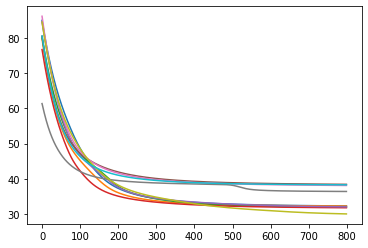

In [65]:
plt.plot(np.array(loss_history_list[10:20]).T)
plt.show()

In [52]:
# approx_E_sig(q_mu[-pixie_dim:], q_cov[-pixie_dim:,-pixie_dim:], V).cpu().detach()
- torch.log(torch.sum(approx_E_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
                                                          q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim],
                                                          V))),approx_E_log_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
                                          q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim], 
                                          torch.unsqueeze(V[x_pred],0))

(tensor(-8.0908, device='cuda:0', grad_fn=<NegBackward>),
 tensor([-4.4387], device='cuda:0', grad_fn=<LogBackward>))

In [64]:
V

tensor([[ 0.7490, -0.4165, -2.0760,  ..., -0.3385, -2.2571,  0.5593],
        [ 0.6637, -0.2536, -2.1230,  ..., -0.5209, -2.1354,  0.4568],
        [-0.4569, -1.1956, -3.3812,  ...,  0.3125, -2.0117,  0.4240],
        ...,
        [-1.0167, -0.5468, -1.1844,  ..., -0.6745, -1.1191, -0.5316],
        [ 0.3117, -0.1325, -2.4875,  ..., -0.4170, -1.9848,  0.2238],
        [-1.1256, -1.0165, -1.3763,  ..., -0.4961, -1.9718, -0.0317]],
       device='cuda:0')

In [71]:
approx_E_sig(q_mu[-pixie_dim:], q_cov[-pixie_dim:,-pixie_dim:], torch.unsqueeze(V[y_pred],0))

tensor([0.8551], device='cuda:0', grad_fn=<SigmoidBackward>)

## MEN dataset

In [11]:
path_men = work_path+'MEN/MEN_dataset_lemma_form.test'

preds1 = []
preds2 = []
POS = []
scores = []
cnt = 0
with open(path_men) as f:
    for line in f:
        cnt+=1
        word1 = line.split(' ')[0].split('-')[0]
        word2 = line.split(' ')[1].split('-')[0]
        if (word1 in predicate_list) and (word2 in predicate_list):
            preds1.append(predicates_table[word1])
            POS.append(line.split(' ')[0].split('-')[1])
            preds2.append(predicates_table[word2])
            scores.append(float(line.split(' ')[2]))
cnt,len(preds1),len(preds2)

(1000, 725, 725)

In [12]:
class VI_single(nn.Module):
    def __init__(self, pixie_dim):
        super(VI_single,self).__init__()
        self.q_mu = nn.Parameter(torch.randn(pixie_dim))
        self.logCovDiag = nn.Parameter(torch.randn(pixie_dim))
        
    def forward(self):
        q_cov = torch.diag(torch.exp(self.logCovDiag))
        return self.q_mu, q_cov

In [ ]:
pixie_dim=20
lr = 0.05
dr = 0.0000000001
loss_history_list = []

pred_scores = []
pred_rank = []
for x1,x2,pos in zip(preds1, preds2, POS):
    model = VI_single(pixie_dim)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = dr)
    
    loss_history = []
    for epoch in range(400):
        if np.mod(30,epoch)==0 & epoch!=0:
            lr = lr *0.3
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay = dr)

        q_mu, q_cov = model()
        optimizer.zero_grad()
        # loss 
        if pos=='j':
            part = 2
        elif pos=='v':
            part = 1
        else:
            part = 0
            
        Dqp = -torch.log(torch.det(q_cov))  \
                        + torch.sum(torch.mul((q_mu-W_mu[pixie_dim*part:pixie_dim*(part+1)]).T,
                                              torch.matmul(torch.inverse(W_cov[pixie_dim*part:pixie_dim*(part+1),pixie_dim*part:pixie_dim*(part+1)]),
                                                           (q_mu-W_mu[pixie_dim*part:pixie_dim*(part+1)]).T))) \
                        + torch.sum(torch.diagonal(torch.matmul(torch.inverse(W_cov[pixie_dim*part:pixie_dim*(part+1),pixie_dim*part:pixie_dim*(part+1)]), q_cov),dim1=-1, dim2=-2))
        
        pred_loss = approx_E_log_sig(q_mu, q_cov, torch.unsqueeze(V[x1],0)) \
                    - torch.log(torch.sum(approx_E_sig(q_mu, q_cov, V)))

#         pred_loss = torch.log(approx_E_sig(q_mu,q_cov, torch.unsqueeze(V[x1],0))) 
#                     - torch.log(torch.sum(approx_E_sig(q_mu, q_cov, V)))
    
        loss = 0.1*Dqp - pred_loss
        
        loss.backward()
        optimizer.step()  
        loss_history.append(loss.item())
    
    loss_history_list.append(loss_history)
    # evaluation
    prob = approx_E_sig(q_mu, q_cov, torch.unsqueeze(V[x2],0))/ \
            torch.sum(approx_E_sig(q_mu, q_cov, V)) 
    
    sorted_truth,truth_index = torch.sort(approx_E_sig(q_mu, q_cov, V).cpu().detach(), descending=True)
    truth_rank = (truth_index == x2).nonzero().item()
    
    pred_rank.append(truth_rank)
    pred_scores.append(approx_E_sig(q_mu, q_cov, torch.unsqueeze(V[x2],0)).cpu().detach())
    print(approx_E_sig(q_mu, q_cov, torch.unsqueeze(V[x1],0)).cpu().detach(),
          approx_E_sig(q_mu, q_cov, torch.unsqueeze(V[x2],0)).cpu().detach(),
          prob.cpu().detach(), Dqp.detach().cpu(), pred_loss.detach().cpu())

    

<ipython-input-28-6a07ff8b4208>:15: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(30,epoch)==0 & epoch!=0:


tensor([0.9148]) tensor([0.0093]) tensor([6.4887e-05]) tensor(39.1419) tensor([-5.2151])
tensor([0.9214]) tensor([0.0027]) tensor([2.6394e-05]) tensor(38.5208) tensor([-4.8474])
tensor([0.8894]) tensor([0.0733]) tensor([0.0003]) tensor(40.2648) tensor([-5.8880])
tensor([0.9204]) tensor([0.0002]) tensor([5.1066e-06]) tensor(39.1573) tensor([-3.9282])
tensor([0.8839]) tensor([0.6122]) tensor([0.0041]) tensor(44.9060) tensor([-5.3259])
tensor([0.9449]) tensor([0.0059]) tensor([0.0001]) tensor(38.6876) tensor([-3.8756])
tensor([0.9225]) tensor([0.0001]) tensor([3.2911e-06]) tensor(37.3499) tensor([-3.9714])
tensor([0.8245]) tensor([0.0001]) tensor([1.8797e-06]) tensor(39.8359) tensor([-4.6953])
tensor([0.9283]) tensor([0.0007]) tensor([1.0863e-05]) tensor(52.7106) tensor([-4.4213])
tensor([0.8961]) tensor([0.2293]) tensor([0.0011]) tensor(38.3358) tensor([-5.6874])
tensor([0.9268]) tensor([0.0004]) tensor([9.4603e-06]) tensor(38.9823) tensor([-3.9512])
tensor([0.8847]) tensor([0.0038]) ten

tensor([0.9242]) tensor([0.9443]) tensor([0.0009]) tensor(38.9496) tensor([-7.2345])
tensor([0.9202]) tensor([0.1927]) tensor([0.0029]) tensor(50.8181) tensor([-4.4075])
tensor([0.9415]) tensor([0.9663]) tensor([0.0003]) tensor(37.4273) tensor([-8.2816])
tensor([0.9229]) tensor([0.8496]) tensor([0.0009]) tensor(40.7378) tensor([-7.0824])
tensor([0.9125]) tensor([0.0011]) tensor([7.0906e-06]) tensor(49.5584) tensor([-5.3839])
tensor([0.8695]) tensor([0.0082]) tensor([0.0001]) tensor(40.0960) tensor([-4.6769])
tensor([0.9218]) tensor([0.0084]) tensor([7.5659e-05]) tensor(40.0961) tensor([-4.9335])
tensor([0.8980]) tensor([0.0416]) tensor([0.0004]) tensor(45.1794) tensor([-4.8305])
tensor([0.8235]) tensor([0.8871]) tensor([0.0026]) tensor(50.8608) tensor([-6.2313])
tensor([0.8927]) tensor([0.9564]) tensor([0.0065]) tensor(47.2638) tensor([-5.3073])
tensor([0.9870]) tensor([0.9923]) tensor([0.0001]) tensor(41.1874) tensor([-9.0517])
tensor([0.9871]) tensor([0.9250]) tensor([0.0001]) tensor

tensor([0.9269]) tensor([0.8899]) tensor([0.0206]) tensor(39.0037) tensor([-3.9464])
tensor([0.9088]) tensor([0.1922]) tensor([0.0004]) tensor(46.5271) tensor([-6.3508])
tensor([0.8850]) tensor([0.7247]) tensor([0.0027]) tensor(37.3082) tensor([-5.8888])
tensor([0.9011]) tensor([0.1719]) tensor([0.0004]) tensor(40.9142) tensor([-6.3709])
tensor([0.8846]) tensor([0.7106]) tensor([0.0024]) tensor(40.3479) tensor([-6.0116])
tensor([0.9098]) tensor([0.0327]) tensor([9.0591e-05]) tensor(49.2762) tensor([-6.2193])
tensor([0.8826]) tensor([0.0105]) tensor([0.0031]) tensor(74.6567) tensor([-1.4529])
tensor([0.8655]) tensor([0.0052]) tensor([2.4412e-05]) tensor(60.9866) tensor([-5.7341])
tensor([0.9869]) tensor([0.9718]) tensor([0.0001]) tensor(41.1891) tensor([-9.0509])
tensor([0.9871]) tensor([0.9889]) tensor([0.0001]) tensor(41.1948) tensor([-9.0519])
tensor([0.9173]) tensor([0.0436]) tensor([0.0006]) tensor(43.9502) tensor([-4.6498])
tensor([0.9253]) tensor([0.0374]) tensor([0.0002]) tensor

tensor([0.9079]) tensor([0.0042]) tensor([6.8821e-05]) tensor(40.3659) tensor([-4.3169])
tensor([0.9252]) tensor([0.5281]) tensor([0.0071]) tensor(39.2779) tensor([-4.5156])
tensor([0.9485]) tensor([0.6523]) tensor([9.7906e-05]) tensor(40.5682) tensor([-9.0022])
tensor([0.9093]) tensor([0.0060]) tensor([8.9283e-05]) tensor(37.3730) tensor([-4.4114])
tensor([0.9093]) tensor([0.0036]) tensor([2.0155e-05]) tensor(47.0476) tensor([-5.4931])
tensor([0.9051]) tensor([0.0055]) tensor([0.0001]) tensor(56.5198) tensor([-4.1096])
tensor([0.9004]) tensor([0.9687]) tensor([0.0093]) tensor(41.7072) tensor([-4.9042])
tensor([0.9333]) tensor([0.0001]) tensor([2.4132e-06]) tensor(41.3640) tensor([-3.9433])
tensor([0.9831]) tensor([0.9195]) tensor([0.0001]) tensor(44.7188) tensor([-8.9605])
tensor([0.8574]) tensor([0.0003]) tensor([1.2816e-06]) tensor(37.5798) tensor([-5.9464])
tensor([0.8812]) tensor([0.0151]) tensor([0.0001]) tensor(57.3870) tensor([-4.9867])
tensor([0.8906]) tensor([0.9682]) tensor(

tensor([0.9395]) tensor([0.9265]) tensor([0.0001]) tensor(40.2703) tensor([-8.9923])
tensor([0.9098]) tensor([0.5170]) tensor([0.0018]) tensor(42.5206) tensor([-5.9470])
tensor([0.9125]) tensor([0.0750]) tensor([0.0008]) tensor(41.3980) tensor([-4.7189])
tensor([0.9829]) tensor([0.5483]) tensor([8.1487e-05]) tensor(44.7449) tensor([-8.9612])
tensor([0.9479]) tensor([0.9757]) tensor([0.0006]) tensor(31.5668) tensor([-7.5997])
tensor([0.9267]) tensor([0.0125]) tensor([0.0002]) tensor(47.9170) tensor([-4.1409])
tensor([0.9316]) tensor([0.0089]) tensor([0.0002]) tensor(41.4586) tensor([-4.1140])
tensor([0.8733]) tensor([0.0118]) tensor([2.7314e-05]) tensor(36.3001) tensor([-6.3704])
tensor([0.8961]) tensor([0.0304]) tensor([0.0002]) tensor(52.3267) tensor([-5.3818])
tensor([0.8579]) tensor([0.0210]) tensor([4.8374e-05]) tensor(55.3753) tensor([-6.4803])
tensor([0.9214]) tensor([0.2816]) tensor([0.0047]) tensor(40.1327) tensor([-4.2922])
tensor([0.9471]) tensor([0.7377]) tensor([0.0001]) te

In [26]:

pd.DataFrame(np.stack([pred_rank, scores]).T).corr(method='spearman')

,0,1
0,1.000000,-0.291543
1,-0.291543,1.000000


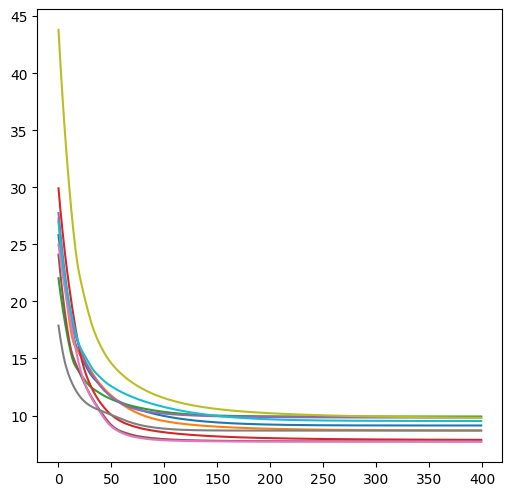

In [27]:
plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(np.array(loss_history_list[:10]).T)
plt.show()

## SimLex999


In [ ]:
path_simlex = '/local/scratch/yl535/SimLex-999/SimLex-999.txt'
df = pd.read_csv(path_simlex, delimiter = "\t")


In [ ]:
words1 = df['word1'].values
words2 = df['word2'].values


cnt = 0
X_eval = []
for idx in range(len(words1)):
    if (words1[idx] in predicate_list) & (words2[idx] in predicate_list):
        X_eval.append([predicates_table[words1[idx]],predicates_table[words2[idx]]])
        cnt+=1     
cnt
X_eval = np.array(X_eval)
POS = df['POS'].values
Y_eval = df['SimLex999'].values

In [10]:
class VI_single(nn.Module):
    def __init__(self, pixie_dim):
        super(VI_single,self).__init__()
        self.q_mu = nn.Parameter(torch.randn(pixie_dim))
        self.logCovDiag = nn.Parameter(torch.randn(pixie_dim))
        
    def forward(self):
        q_cov = torch.diag(torch.exp(self.logCovDiag))
        return self.q_mu, q_cov

In [59]:
pixie_dim=20
lr = 0.1
dr = 0.01
loss_history_list = []
for X,Y,pos in zip(X_eval, Y_eval,POS):
    model = VI_single(pixie_dim)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = dr)
    
    loss_history = []
    for epoch in range(300):
        if np.mod(30,epoch)==0 & epoch!=0:
            lr = lr *0.7
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = dr)

        q_mu, q_cov = model()
        optimizer.zero_grad()
        # loss 
        if pos=='A':
            part = 2
        elif pos=='V':
            part = 1
        else:
            part = 0
            
        Dqp = -torch.log(torch.det(q_cov))  \
                        + torch.sum(torch.mul((q_mu-W_mu[pixie_dim*part:pixie_dim*(part+1)]).T,
                                              torch.matmul(torch.inverse(W_cov[pixie_dim*part:pixie_dim*(part+1),pixie_dim*part:pixie_dim*(part+1)]),
                                                           (q_mu-W_mu[pixie_dim*part:pixie_dim*(part+1)]).T))) \
                        + torch.sum(torch.diagonal(torch.matmul(torch.inverse(W_cov[pixie_dim*part:pixie_dim*(part+1),pixie_dim*part:pixie_dim*(part+1)]), q_cov),dim1=-1, dim2=-2))
        
        pred_loss = approx_E_log_sig(q_mu, q_cov, torch.unsqueeze(V[X[0]],0))*2 \
                    - torch.log(torch.sum(approx_E_sig(q_mu, q_cov, V)))

            
        loss = 0.1*Dqp - pred_loss
        
        loss.backward()
        optimizer.step()  
        loss_history.append(loss.item())
    
    loss_history_list.append(loss_history)
    # evaluation
    pred_eval = X[1]
    prob = approx_E_sig(q_mu, q_cov, torch.unsqueeze(V[pred_eval],0))/ \
            torch.sum(approx_E_sig(q_mu, q_cov, V))    

    print(approx_E_sig(q_mu, q_cov, torch.unsqueeze(V[X[0]],0)).cpu().detach(),
          approx_E_sig(q_mu, q_cov, torch.unsqueeze(V[pred_eval],0)).cpu().detach(),
          prob.cpu().detach(), Dqp.detach().cpu(), pred_loss.detach().cpu())

    

<ipython-input-59-65388c6f5fe7>:12: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(30,epoch)==0 & epoch!=0:


tensor([0.9549]) tensor([0.9047]) tensor([0.0001]) tensor(31.4354) tensor([-8.9246])
tensor([0.9499]) tensor([0.9612]) tensor([0.0001]) tensor(31.4015) tensor([-8.9266])
tensor([0.9596]) tensor([0.9469]) tensor([0.0001]) tensor(31.9030) tensor([-8.9393])
tensor([0.9437]) tensor([0.8351]) tensor([0.0001]) tensor(31.0641) tensor([-8.8750])
tensor([0.9603]) tensor([0.9696]) tensor([0.0001]) tensor(32.4335) tensor([-8.9543])
tensor([0.9581]) tensor([0.9508]) tensor([0.0001]) tensor(31.8297) tensor([-8.9390])
tensor([0.9595]) tensor([0.9574]) tensor([0.0001]) tensor(32.2086) tensor([-8.9490])
tensor([0.9549]) tensor([0.9344]) tensor([0.0001]) tensor(31.4354) tensor([-8.9246])
tensor([0.9607]) tensor([0.9621]) tensor([0.0001]) tensor(32.2882) tensor([-8.9483])
tensor([0.9437]) tensor([0.8744]) tensor([0.0001]) tensor(31.0641) tensor([-8.8750])
tensor([0.9536]) tensor([0.9351]) tensor([0.0001]) tensor(31.7256) tensor([-8.9424])
tensor([0.9521]) tensor([0.8999]) tensor([0.0001]) tensor(31.5969

tensor([0.9511]) tensor([0.9405]) tensor([0.0001]) tensor(31.6007) tensor([-8.9401])
tensor([0.8870]) tensor([0.0002]) tensor([1.5827e-05]) tensor(41.0569) tensor([-3.0193])
tensor([0.9611]) tensor([0.9576]) tensor([0.0001]) tensor(32.0820) tensor([-8.9429])
tensor([0.9628]) tensor([0.9680]) tensor([0.0001]) tensor(32.2352) tensor([-8.9446])
tensor([0.9132]) tensor([2.3334e-05]) tensor([3.0024e-06]) tensor(35.9532) tensor([-2.2995])
tensor([0.8306]) tensor([0.0037]) tensor([4.2671e-05]) tensor(50.5747) tensor([-5.0319])
tensor([0.8810]) tensor([0.0168]) tensor([0.0014]) tensor(35.6845) tensor([-2.8259])
tensor([0.9052]) tensor([0.0001]) tensor([7.3895e-06]) tensor(36.9343) tensor([-3.2054])
tensor([0.9106]) tensor([3.5457e-05]) tensor([3.1853e-06]) tensor(32.9871) tensor([-2.6558])
tensor([0.9147]) tensor([9.3110e-05]) tensor([9.6077e-06]) tensor(35.3048) tensor([-2.5119])
tensor([0.8992]) tensor([0.0001]) tensor([9.3917e-06]) tensor(35.1626) tensor([-2.6764])
tensor([0.9499]) tensor([

tensor([0.9086]) tensor([0.0001]) tensor([8.2411e-06]) tensor(37.8313) tensor([-3.0451])
tensor([0.9537]) tensor([0.9633]) tensor([0.0001]) tensor(36.4617) tensor([-8.9691])
tensor([0.8539]) tensor([0.0002]) tensor([8.9887e-06]) tensor(45.0976) tensor([-3.6837])
tensor([0.9384]) tensor([0.8891]) tensor([0.0001]) tensor(35.8352) tensor([-8.9716])
tensor([0.9521]) tensor([0.9457]) tensor([0.0001]) tensor(35.9995) tensor([-8.9535])
tensor([0.8128]) tensor([0.0160]) tensor([0.0001]) tensor(54.3483) tensor([-5.5603])
tensor([0.9310]) tensor([0.8950]) tensor([0.0001]) tensor(35.4590) tensor([-8.9422])
tensor([0.8649]) tensor([0.0002]) tensor([1.1266e-05]) tensor(42.6027) tensor([-3.3935])
tensor([0.9479]) tensor([0.9463]) tensor([0.0001]) tensor(36.1309) tensor([-8.9678])
tensor([0.9551]) tensor([0.9574]) tensor([0.0001]) tensor(36.4384) tensor([-8.9657])
tensor([0.8879]) tensor([0.0004]) tensor([1.0633e-05]) tensor(39.0243) tensor([-3.8348])
tensor([0.9427]) tensor([0.8990]) tensor([0.0001]

tensor([1.0000]) tensor([1.4861e-05]) tensor([2.7747e-06]) tensor(27.4907) tensor([-1.6782])
tensor([0.9427]) tensor([0.5959]) tensor([9.1841e-05]) tensor(35.4910) tensor([-8.9481])
tensor([0.8539]) tensor([0.0039]) tensor([0.0002]) tensor(45.1000) tensor([-3.6842])
tensor([0.8701]) tensor([0.0010]) tensor([3.5342e-05]) tensor(48.6161) tensor([-3.7047])
tensor([0.9545]) tensor([0.9567]) tensor([0.0001]) tensor(36.4531) tensor([-8.9684])
tensor([0.8967]) tensor([0.0001]) tensor([1.1441e-05]) tensor(36.9583) tensor([-2.5490])
tensor([0.8700]) tensor([0.0003]) tensor([1.1203e-05]) tensor(38.6493) tensor([-3.6656])
tensor([0.9084]) tensor([5.6618e-05]) tensor([5.3274e-06]) tensor(35.4559) tensor([-2.6162])
tensor([0.9469]) tensor([0.8848]) tensor([0.0001]) tensor(35.6094) tensor([-8.9498])
tensor([0.9543]) tensor([0.7019]) tensor([0.0001]) tensor(36.5003) tensor([-8.9680])
tensor([0.9516]) tensor([0.9492]) tensor([0.0001]) tensor(36.4778) tensor([-8.9714])
tensor([0.9518]) tensor([0.9601])

tensor([0.9533]) tensor([0.9326]) tensor([0.0001]) tensor(36.4068) tensor([-8.9664])
tensor([0.9208]) tensor([3.5858e-05]) tensor([4.8884e-06]) tensor(36.3622) tensor([-2.2166])
tensor([0.9521]) tensor([0.9518]) tensor([0.0001]) tensor(36.5202) tensor([-8.9714])
tensor([0.9528]) tensor([0.9589]) tensor([0.0001]) tensor(36.3701) tensor([-8.9644])
tensor([0.9494]) tensor([0.4358]) tensor([6.4832e-05]) tensor(36.3749) tensor([-8.9706])
tensor([0.9494]) tensor([0.9378]) tensor([0.0001]) tensor(36.3743) tensor([-8.9706])
tensor([0.9494]) tensor([0.9482]) tensor([0.0001]) tensor(36.3760) tensor([-8.9705])
tensor([0.9496]) tensor([0.9419]) tensor([0.0001]) tensor(36.3883) tensor([-8.9711])
tensor([0.9500]) tensor([0.9411]) tensor([0.0001]) tensor(36.1193) tensor([-8.9636])
tensor([0.9469]) tensor([0.9344]) tensor([0.0001]) tensor(36.0466) tensor([-8.9698])
tensor([0.9528]) tensor([0.8489]) tensor([0.0001]) tensor(36.2732) tensor([-8.9616])
tensor([0.9462]) tensor([0.9250]) tensor([0.0001]) te

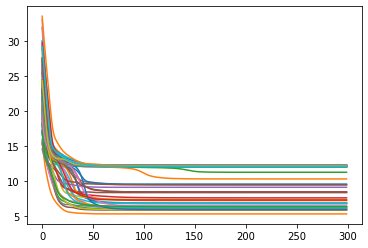

In [58]:
plt.plot(np.array(loss_history_list[:80]).T)

## GS2011

In [7]:
import pandas as pd 
df = pd.read_csv('/local/scratch/yl535/GS2011data.txt', delimiter = " ")
df[['subject','verb','object']].values
df.landmark.values


array(['supply', 'leave', 'supply', ..., 'state', 'allege', 'state'],
      dtype=object)

In [7]:
# path_gs11 = '/local/scratch/yl535/GS2011data.txt'
path_gs11 = '../GS2011data.txt'

In [8]:
df = pd.read_csv(path_gs11, delimiter = " ")


In [9]:
subjs = df['subject'].values
objs = df['object'].values
verbs1 = df['verb'].values
verbs2 = df['landmark'].values
Y_eval = df['input'].values

In [10]:
cnt = 0
X_eval = []
Y_eval = []
for idx in range(len(subjs)):
    if ((subjs[idx] in predicate_list) & (objs[idx] in predicate_list) \
    & (verbs1[idx] in predicate_list) & (verbs2[idx] in predicate_list)):
        cnt+=1
        X_eval.append([predicates_table[subjs[idx]],
                      predicates_table[verbs1[idx]],
                      predicates_table[objs[idx]]])
        Y_eval.append(predicates_table[verbs2[idx]])
        
cnt

197

In [19]:

pixie_dim=20
lr = 0.05
dr = 0.001
loss_history_list = []
for X,Y in zip(X_eval, Y_eval):

    model = VI(pixie_dim)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = dr)
    
    loss_history = []
    for epoch in range(300):
        if np.mod(50,epoch)==0 & epoch!=0:
            lr = lr *0.5
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = dr)

        q_mu, q_cov = model()
        optimizer.zero_grad()
        # loss 
        Dqp = -torch.log(torch.det(q_cov))  \
                        + torch.sum(torch.mul((q_mu-W_mu).T, torch.matmul(torch.inverse(W_cov), (q_mu-W_mu).T))) \
                        + torch.sum(torch.diagonal(torch.matmul(torch.inverse(W_cov), q_cov),dim1=-1, dim2=-2))

        pred_loss = 0
        for idx, x_pred in enumerate(X):
            pred_loss += approx_E_log_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
                                          q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim], 
                                          torch.unsqueeze(V[x_pred],0)) \
                                     - torch.log(torch.sum(approx_E_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
                                                          q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim],
                                                          V)))
            
        loss = 0.1*Dqp - pred_loss
        
        loss.backward()
        optimizer.step()  
        loss_history.append(loss.item())
    
    loss_history_list.append(loss_history)
    # evaluation
    idx = 1
    prob = approx_E_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
                        q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim],
                        torch.unsqueeze(V[Y],0))/ \
            torch.sum(approx_E_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
                                   q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim], V))

    print(approx_E_sig(q_mu[idx*pixie_dim:(idx+1)*pixie_dim],
                        q_cov[idx*pixie_dim:(idx+1)*pixie_dim, idx*pixie_dim:(idx+1)*pixie_dim],
                        torch.unsqueeze(V[Y],0)).cpu().detach(),
        prob.cpu().detach(), Dqp.detach().cpu(), pred_loss.detach().cpu())

    

<ipython-input-19-4231ee1f8868>:13: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(50,epoch)==0 & epoch!=0:


tensor([0.9588]) tensor([0.0001]) tensor(115.1602) tensor([-26.6854])
tensor([0.9348]) tensor([0.0001]) tensor(151.1225) tensor([-21.0040])
tensor([0.9447]) tensor([0.0001]) tensor(132.2470) tensor([-24.0888])
tensor([0.9048]) tensor([0.0001]) tensor(134.3980) tensor([-17.7592])
tensor([0.9563]) tensor([0.0001]) tensor(114.9678) tensor([-26.6566])
tensor([0.9577]) tensor([0.0001]) tensor(115.4336) tensor([-26.6871])
tensor([0.9451]) tensor([0.0001]) tensor(130.7079) tensor([-24.2770])
tensor([0.9440]) tensor([0.0001]) tensor(131.5873) tensor([-24.1628])
tensor([0.9043]) tensor([0.0001]) tensor(134.0790) tensor([-17.7576])
tensor([0.9559]) tensor([0.0001]) tensor(115.2453) tensor([-26.6559])
tensor([0.9580]) tensor([0.0001]) tensor(115.0302) tensor([-26.6859])
tensor([0.9343]) tensor([0.0001]) tensor(150.4736) tensor([-21.0357])
tensor([0.9440]) tensor([0.0001]) tensor(132.1746) tensor([-24.0812])
tensor([0.9038]) tensor([0.0001]) tensor(134.5979) tensor([-17.6958])
tensor([0.9567]) ten

KeyboardInterrupt: 

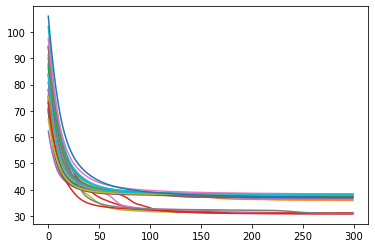

In [20]:
plt.plot(np.array(loss_history_list[:80]).T)